In [1]:
%matplotlib inline
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch import save

In [2]:
class ConfigClass():
    train_batch_size = 32
    train_num_epochs = 50

In [23]:
class SiameseDataset(Dataset):

    
    def __init__(self,transform = None, invert = False):
        with open('train_index.pkl', 'rb') as train_index_file:
            self.pairs = pickle.load(train_index_file)
        self.transform = transform
        self.invert = invert
        
        
    def __getitem__(self, index):
        item = self.pairs[index]
        img_1 = Image.open(item[0]).convert("L")
        img_2 = Image.open(item[1]).convert("L")
        
        if self.invert:
            img_1 = PIL.ImageOps.invert(img_1)
            img_2 = PIL.ImageOps.invert(img_2)
        
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
        
          
        return [img_1, img_2, torch.from_numpy(np.array(np.float32(item[2])))]
    
    def __len__(self):
        return len(self.pairs)


In [4]:
import pickle
with open('train_index.pkl', 'rb') as train_index_file:
    train_folder = pickle.load(train_index_file)
siamese_dataset = SiameseDataset(image_folder=train_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)


In [5]:
def imshow(img, text=None):
    np_img = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

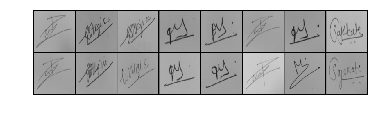

array([0., 0., 1., 0., 0., 0., 1., 1.], dtype=float32)

In [10]:
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=1, batch_size=8)
data_iter = iter(dataloader)
vis_batch = next(data_iter)
merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
imshow(torchvision.utils.make_grid(merged))
vis_batch[2].numpy()

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.reflection_pad = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(4)
        self.batch_norm2 = nn.BatchNorm2d(8) 
        self.fc1 = nn.Linear(8 * 100 * 100, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 5)
        
    def forward_one_branch(self, x):
        x = self.batch_norm1(self.relu(self.conv1(self.reflection_pad(x))))
        x = self.batch_norm2(self.relu(self.conv2(self.reflection_pad(x))))        
        x = self.batch_norm2(self.relu(self.conv3(self.reflection_pad(x))))   
        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))        
        x = self.fc3(x)
        
        return x
        
    def forward(self, input1, input2):
        output1 = self.forward_one_branch(input1)
        output2 = self.forward_one_branch(input2)     
        
        return output1, output2


# In[37]:


class ConstrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ConstrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2, keepdim=True)
        contrastive_loss = torch.mean((1 - label)*torch.pow(distance, 2)
                                      + (label)*torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        
        return contrastive_loss


# In[38]:


dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=ConfigClass.train_batch_size)
model = SiameseNetwork()
criterion = ConstrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

counter = []
loss_history = []
iteration = 0

Epoch: 0 	 Loss: 1.5892667770385742
Epoch: 1 	 Loss: 1.1382026672363281
Epoch: 2 	 Loss: 1.0987184047698975
Epoch: 3 	 Loss: 1.0855400562286377
Epoch: 4 	 Loss: 1.1554688215255737
Epoch: 5 	 Loss: 1.0006216764450073
Epoch: 6 	 Loss: 1.1086026430130005
Epoch: 7 	 Loss: 1.1097089052200317
Epoch: 8 	 Loss: 1.0993072986602783
Epoch: 9 	 Loss: 1.069339632987976
Epoch: 10 	 Loss: 1.1611860990524292
Epoch: 11 	 Loss: 0.9698352813720703
Epoch: 12 	 Loss: 1.087683916091919
Epoch: 13 	 Loss: 1.1098196506500244
Epoch: 14 	 Loss: 1.0701897144317627
Epoch: 15 	 Loss: 1.0012723207473755
Epoch: 16 	 Loss: 1.0744839906692505
Epoch: 17 	 Loss: 1.0620380640029907
Epoch: 18 	 Loss: 1.093454122543335
Epoch: 19 	 Loss: 1.0211538076400757
Epoch: 20 	 Loss: 1.081737995147705
Epoch: 21 	 Loss: 1.0863304138183594
Epoch: 22 	 Loss: 1.1361517906188965
Epoch: 23 	 Loss: 1.074731707572937
Epoch: 24 	 Loss: 1.0686908960342407
Epoch: 25 	 Loss: 1.0542700290679932
Epoch: 26 	 Loss: 1.0380743741989136
Epoch: 27 	 Loss

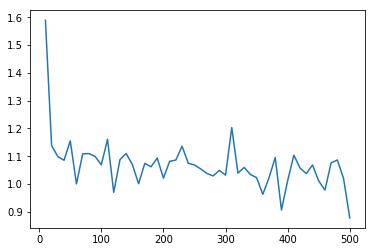

In [12]:
for epoch in range(ConfigClass.train_num_epochs):
    for i, data in enumerate(dataloader, 0):
        input1, input2, label = data
        input1, input2, label = input1, input2, label
        optimizer.zero_grad()

        output1, output2 = model(input1, input2)
        contrastive_loss = criterion(output1, output2, label)
        contrastive_loss.backward()
        optimizer.step()
        
        if (i+1) % 16 == 0:
            print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
            iteration += 10
            loss_history.append(contrastive_loss.item())
            counter.append(iteration)
            
       # file_path = "Models/model_epoch_%d" % epoch
       # with open(file_path, 'wb') as f:
           
        filename = "epoch_%d"% epoch+'.sav'
        pickle.dump(model, open(filename, 'wb'))       #    save(model.state_dict(), f)  
                
show_plot(counter, loss_history)


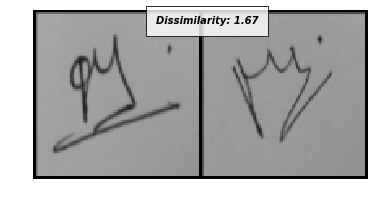

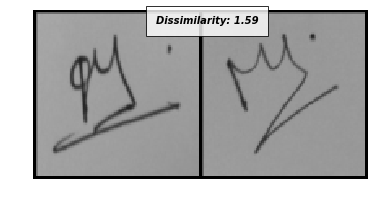

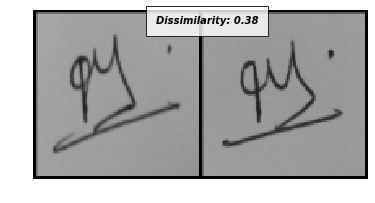

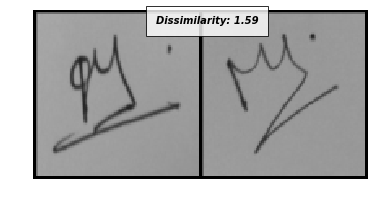

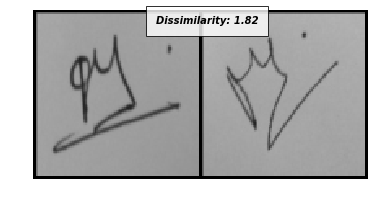

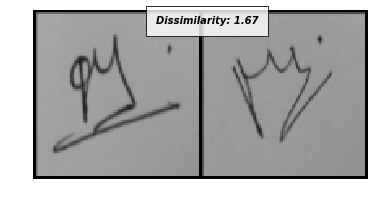

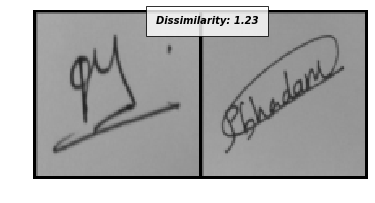

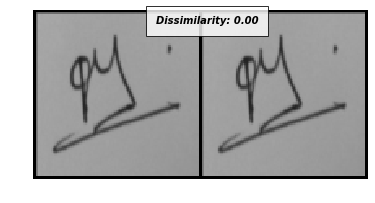

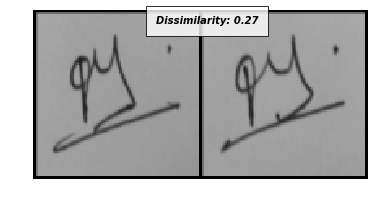

In [70]:
# Test program

class SiameseDataset(Dataset):
    
    def __init__(self, image_folder, transform = None, invert = False):
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert
        
    def __getitem__(self, index):
        sample_1 = random.choice(self.image_folder.imgs)
        same_class = random.randint(0, 1)
        
        if same_class:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break
        else:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break
        
        img_1 = Image.open(sample_1[0]).convert("L")
        img_2 = Image.open(sample_2[0]).convert("L")
        
        if self.invert:
            img_1 = PIL.ImageOps.invert(img_1)
            img_2 = PIL.ImageOps.invert(img_2)
        
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
            
        return img_1, img_2, torch.from_numpy(np.array([int(sample_1[1] != sample_2[1])], dtype = np.float32))
    



    def __len__(self):
        return len(self.image_folder.imgs)



class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.reflection_pad = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(4)
        self.batch_norm2 = nn.BatchNorm2d(8) 
        self.fc1 = nn.Linear(8 * 100 * 100, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 5)
        
    def forward_one_branch(self, x):
        x = self.batch_norm1(self.relu(self.conv1(self.reflection_pad(x))))
        x = self.batch_norm2(self.relu(self.conv2(self.reflection_pad(x))))        
        x = self.batch_norm2(self.relu(self.conv3(self.reflection_pad(x))))   
        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))        
        x = self.fc3(x)
        
        return x
        
    def forward(self, input1, input2):
        output1 = self.forward_one_branch(input1)
        output2 = self.forward_one_branch(input2)     
        
        return output1, output2





###################################################


def imshow(img, text=None):
    np_img = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()    

class ConfigClass():
    #train_dir = 'data/Signature4/training/'
    test_dir = 'data2/'
    
loaded_model = pickle.load(open('epoch_49.sav', 'rb'))

test_folder = dataset.ImageFolder(root=ConfigClass.test_dir)



siamese_dataset = SiameseDataset(image_folder=test_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)


dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1)
data_iter = iter(dataloader)




img0, _, _ = next(data_iter)



for i in range(9):
    _, img1, label = next(data_iter)
    merged = torch.cat((img0,img1), 0)
    
    output1, output2 = loaded_model(Variable(img0), Variable(img1))
    distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(merged), 'Dissimilarity: {:.2f}'.format(distance.item()))

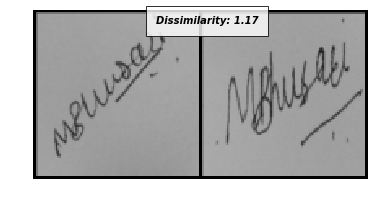

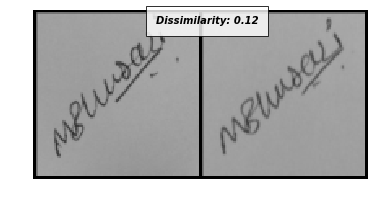

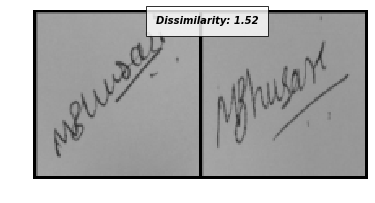

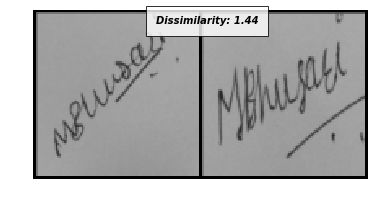

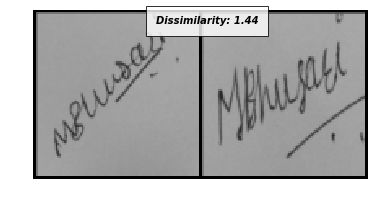

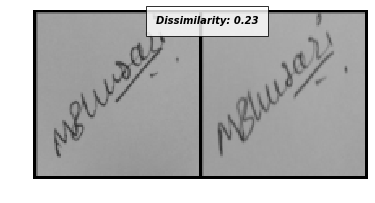

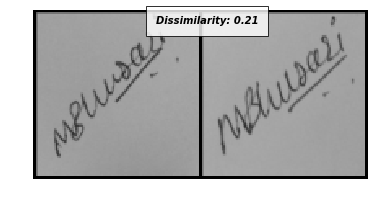

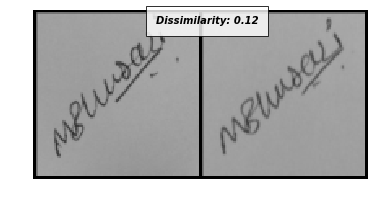

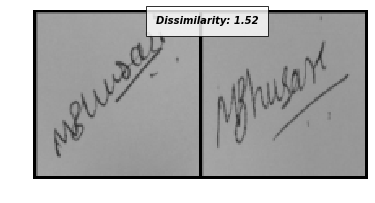

In [71]:
class ConfigClass():
    #train_dir = 'data/Signature4/training/'
    test_dir = 'data1/'
    
loaded_model = pickle.load(open('epoch_49.sav', 'rb'))

test_folder = dataset.ImageFolder(root=ConfigClass.test_dir)



siamese_dataset = SiameseDataset(image_folder=test_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)


dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1)
data_iter = iter(dataloader)




img0, _, _ = next(data_iter)



for i in range(9):
    _, img1, label = next(data_iter)
    merged = torch.cat((img0,img1), 0)
    
    output1, output2 = loaded_model(Variable(img0), Variable(img1))
    distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(merged), 'Dissimilarity: {:.2f}'.format(distance.item()))